## Import Libraries and Instiate Deconv Module

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!rm DeconvModels.py # remove the file if it's already in the folder
!rm training_functions.py # remove the file if it's already in the folder
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/Models/DeconvModels.py -q
!wget https://raw.githubusercontent.com/viibrem/ml_masters_uct/master/PyTorch/util/training_functions.py -q
from DeconvModels import Deconv2D
from training_functions import train_classification_model

rm: cannot remove 'DeconvModels.py': No such file or directory
rm: cannot remove 'training_functions.py': No such file or directory


## Load CIFAR Dataset

In [ ]:
from torchvision import datasets

transform = T.Compose([T.ToTensor(),
                       T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_data = datasets.CIFAR100("/content/", download=True, transform=transform)
data_len = len(cifar_data)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/cifar-100-python.tar.gz to /content/


In [ ]:
dataloader = DataLoader(cifar_data, batch_size=32, shuffle=True)

## Create training function

In [ ]:
class ConvNetTiny2(nn.Module):
    def __init__(self, deconv=True, classes=10):
        super(ConvNetTiny2, self).__init__()

        n_ftrs = 3
        if not deconv:
            self.deconv = nn.Conv2d(3, 3, 3, padding='same')
            self.conv1 = nn.Conv2d(3, 3, 3, padding='same')
        else:
            self.deconv = Deconv2D((4, 4))
            self.conv1 = nn.Conv2d(3, 3, 3, padding='same')
        
        self.bn1 = nn.BatchNorm2d(n_ftrs)

        self.conv2 = nn.Conv2d(n_ftrs, 64, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)

        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(8192, 64)
        self.fc2 = nn.Linear(64, 100)

    
    def forward(self, x):
        x = self.deconv(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

## Train model with no deconv layer

In [ ]:
model = ConvNetTiny2(deconv=True)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history_deconv = train_classification_model(model, criterion, optimizer, dataloader, num_epochs=5)

Epoch  1/5


100%|██████████| 1563/1563 [01:49<00:00, 14.24it/s]


Loss: 5745.3065, Acc: 0.159
Epoch  2/5


100%|██████████| 1563/1563 [01:51<00:00, 14.04it/s]


Loss: 4630.7599, Acc: 0.281
Epoch  3/5


100%|██████████| 1563/1563 [01:49<00:00, 14.25it/s]


Loss: 4069.4562, Acc: 0.356
Epoch  4/5


100%|██████████| 1563/1563 [01:49<00:00, 14.31it/s]


Loss: 3672.9184, Acc: 0.410
Epoch  5/5


100%|██████████| 1563/1563 [01:49<00:00, 14.25it/s]

Loss: 3349.3169, Acc: 0.460


## Train model with deconv layer

In [ ]:
model = ConvNetTiny2(deconv=False)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

history_conv = train_classification_model(model, criterion, optimizer, dataloader, num_epochs=5)
# print(model.deconv.w_flat)

Epoch  1/5


100%|██████████| 1563/1563 [01:43<00:00, 15.16it/s]


Loss: 5803.0965, Acc: 0.154
Epoch  2/5


100%|██████████| 1563/1563 [01:41<00:00, 15.38it/s]


Loss: 4647.7293, Acc: 0.281
Epoch  3/5


100%|██████████| 1563/1563 [01:41<00:00, 15.37it/s]


Loss: 4096.7215, Acc: 0.352
Epoch  4/5


100%|██████████| 1563/1563 [01:41<00:00, 15.33it/s]


Loss: 3706.0770, Acc: 0.403
Epoch  5/5


100%|██████████| 1563/1563 [01:43<00:00, 15.17it/s]

Loss: 3388.5461, Acc: 0.451


## Train model with Deconv and Conv layer

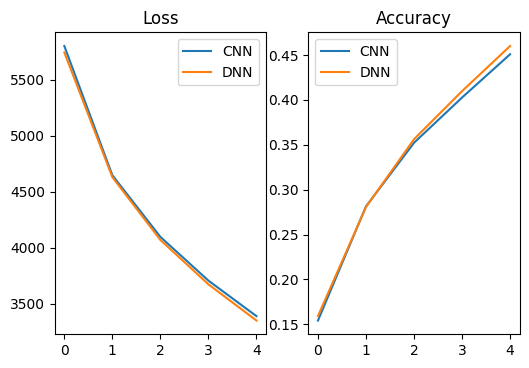

In [ ]:
plt.rcParams['figure.dpi'] = 100
plt.subplots(1, 2)

plt.subplot(1, 2, 1)
plt.plot(history_conv['loss'])
plt.plot(history_deconv['loss'])

plt.legend(['CNN', 'DNN', 'BOTH'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_conv['accuracy'])
plt.plot(history_deconv['accuracy'])
plt.legend(['CNN', 'DNN', 'BOTH'])
plt.title('Accuracy')
plt.show()